In [ ]:
# Import Packages
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import json
import glob
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive (if your dataset is stored there)
drive.mount('/content/drive')

# Define paths to dataset
train_path = "/content/drive/MyDrive/AML/Data/Train/"  # Update this path
test_path = "/content/drive/MyDrive/AML/Data/Test/"  # Update this path

Mounted at /content/drive


In [ ]:
# Load Dataset and Create Labels Dictionary
cwd = os.getcwd()
ROOT_DIR = train_path

labels = {}
for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = list(labels.keys())

In [ ]:
# Load DINOv2 Model and Compute Embeddings
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 192MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
print(dinov2_vits14)  # Print the DINOv2 model architecture

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
# Define Transformation for Images
transform_image = T.Compose([
    T.ToTensor(),
    T.Resize(224),
    T.Normalize([0.5], [0.5])
])

In [ ]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)
    transformed_img = transform_image(img)[:3].unsqueeze(0)
    return transformed_img

In [ ]:
def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
        for i, file in enumerate(tqdm(files)):
            embeddings = dinov2_vits14(load_image(file).to(device))
            all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

# Compute Embeddings
embeddings = compute_embeddings(files)

  0%|          | 0/4829 [00:00<?, ?it/s]

In [ ]:
# Train SVM Classifier
clf = svm.SVC(gamma='scale')
y = [labels[file] for file in files]
embedding_list = list(embeddings.values())

# Train SVM Classifier
clf.fit(np.array(embedding_list).reshape(-1, 384), y)

SVC()

In [ ]:
# Evaluation Metrics
def evaluate_model(clf, embeddings, labels, files):
    y_true = [labels[file] for file in files]
    y_pred = []

    with torch.no_grad():
        for file in tqdm(files):
            embedding = dinov2_vits14(load_image(file).to(device))
            prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))
            y_pred.append(prediction[0])

    # Calculate Top-1 Accuracy
    top1_accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {top1_accuracy}")

    # Calculate Average Accuracy per Class
    report = classification_report(y_true, y_pred, output_dict=True)
    avg_per_class = np.mean([report[label]['recall'] for label in set(y_true)])
    print(f"Average Accuracy per Class: {avg_per_class}")

    # # Calculate Top-5 Accuracy (Placeholder as sklearn does not directly support Top-5)
    # top5_accuracy = None  # Need to implement this manually if relevant data is available
    # print(f"Top-5 Accuracy: {top5_accuracy}")
    # prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))
    # y_pred.append(prediction[0])

# Evaluate Model
evaluate_model(clf, embeddings, labels, files)

  0%|          | 0/4829 [00:00<?, ?it/s]

Top-1 Accuracy: 0.9842617519155105
Average Accuracy per Class: 0.9834941309577994


In [ ]:
# Evaluate Model on Test Data
def evaluate_test_model(clf, test_path):
    test_labels = {}
    test_files = []
    for folder in os.listdir(test_path):
        for file in os.listdir(os.path.join(test_path, folder)):
            if file.endswith(".jpg"):
                full_name = os.path.join(test_path, folder, file)
                test_labels[full_name] = folder
                test_files.append(full_name)

    evaluate_model(clf, compute_embeddings(test_files), test_labels, test_files)

# Run Evaluation on Test Data
evaluate_test_model(clf, test_path)



  0%|          | 0/1204 [00:00<?, ?it/s]

  0%|          | 0/1204 [00:00<?, ?it/s]

Top-1 Accuracy: 0.8264119601328903
Average Accuracy per Class: 0.8217857142857143


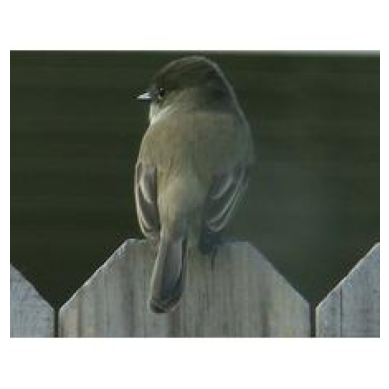

Predicted class: Acadian_Flycatcher


In [ ]:
# Classify an Image
input_file = "/content/drive/MyDrive/AML/Data/Test/Acadian_Flycatcher/0209.jpg"
if os.path.exists(input_file):
    new_image = load_image(input_file)

    plt.imshow(Image.open(input_file))
    plt.axis('off')
    plt.show()

    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print("Predicted class: " + prediction[0])
else:
    print(f"Error: The file {input_file} does not exist. Please provide a valid image path.")

In [ ]:
# Save the trained model
import joblib
joblib.dump(clf, '/content/drive/MyDrive/AML/dinov2_image_classifier_model.pkl')


['/content/drive/MyDrive/AML/dinov2_image_classifier_model.pkl']